In [1]:
import math
import random

# for plotting confusion matrices
import matplotlib.pyplot as plt

# for eigenvalues and eigenvectors in PCA, numpy is used
from numpy import linalg

# scipy is only used as a source for critical values of chi square
from scipy.stats import chi2

# evaluation metrics are computed with sklearn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# importing models
from DecisionTree import DecisionTree as dt
from CategoricalNaiveBayes import CategoricalNaiveBayes as cnb
from SupportVectorMachines import SupportVectorMachines as svm

## Preprocessing

### Label Encoding

Here we load the data and label encode the categorical variables. The data is split into the features and the labels.

In [2]:
# Age - continuous
# Sex - categorical, binary nominal
# BP - categorical, ordinal
# Cholesterol - categorical, binary ordinal
# Na_to_K - continuous
# Drug - categorical, nominal - DEPENDANT VARIABLE

with open('drug_dataset.csv', 'r', encoding='utf8') as file:
    lines = file.readlines()
    samples = [list(line.split('\n')[0].split(',')) for line in lines][1:]
# First we label-encode ordinal categorical predictors
# We also one-hot encode non-ordinal categorical predictors and the dependant variable

for index, sample in enumerate(samples):
    sample[0] = int(sample[0]) # Age
    sample[1] = [1, 0] if sample[1] == 'M' else [0, 1] # Sex
    sample[2] = 0 if sample[2] == 'LOW' else 1 if sample[2] == 'NORMAL' else 2 # BP
    sample[3] = 0 if sample[3] == 'NORMAL' else 1 # Cholesterol
    sample[4] = float(sample[4]) # Na_to_K
    sample[5] = [1,0,0,0,0] if sample[5] == 'drugA' else [0,1,0,0,0] if sample[5] == 'drugB' else [0,0,1,0,0] if sample[5] == 'drugC' else [0,0,0,1,0] if sample[5] == 'drugX' else [0,0,0,0,1] # Drug

    # flatten
    flattened_sample = []
    
    for item in sample:
        if type(item) == list:
            for i in item:
                flattened_sample.append(i)
        else:
            flattened_sample.append(item)
            
    samples[index] = tuple(flattened_sample)

# all encoded variables
age_col = [x[0] for x in samples]
male_col = [x[1] for x in samples]
female_col = [x[2] for x in samples]
bp_col = [x[3] for x in samples]
cholesterol_col = [x[4] for x in samples]
na_to_k_col = [x[5] for x in samples]
drugA_col = [x[6] for x in samples]
drugB_col = [x[7] for x in samples]
drugC_col = [x[8] for x in samples]
drugX_col = [x[9] for x in samples]
drugY_col = [x[10] for x in samples]

# label-encoded versions of sex and drugs
sex_col = [i[1:3].index(1) for i in samples] # used only for feature selection
drugs_col = [i[-5:].index(1) for i in samples] # categorical labels of dependant variable

# splitting features from labels
feature_matrix = [x[0:6] for x in samples]

### Binning Continuous Variables

One of the selected models, the Categorical Naive Bayes, expects all features to be categorical. Here we analyse our continuous variables and bin them into categories.

In [3]:
# analysing continuous variables to decide on bin sizes and range

print('Highest age: ', max(age_col), '\nLowest age: ',  min(age_col), '\nAge range: ', max(age_col) - min(age_col))
print('\nHighest Na_to_K: ', max(na_to_k_col),  '\nLowest Na_to_K: ', min(na_to_k_col), '\nNa_to_K range: ', max(na_to_k_col) - min(na_to_k_col))

Highest age:  74 
Lowest age:  15 
Age range:  59

Highest Na_to_K:  38.247 
Lowest Na_to_K:  6.269 
Na_to_K range:  31.978


In [4]:
# we will take bin sizes of 5 for age
age_bin_edges = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

# we will take bin sizes of 2.5 for na_to_k
natok_bin_edges = [8.769, 11.269, 13.769, 16.269, 18.769, 21.269, 23.769, 26.269, 28.769, 31.269, 33.769, 36.269, 38.769]

# binning of contiuous features into categorical ones (for Categorical Naive Bayes)
categorised_features = []

for row in feature_matrix:
    new_row = list(row)

    # binning age
    for i in range(len(age_bin_edges)):
        if i == 0 and (new_row[0] < age_bin_edges[i]):
            new_row[0] = i
            
        elif i != 0 and (age_bin_edges[i-1] <= new_row[0] < age_bin_edges[i]):
            new_row[0] = i
            
    # binning na_to_k
    for i in range(len(natok_bin_edges)):
        if i == 0 and (new_row[-1] < natok_bin_edges[i]):
            new_row[-1] = i
        elif i != 0 and (natok_bin_edges[i-1] <= new_row[-1] < natok_bin_edges[i]):
            new_row[-1] = i
            
    categorised_features.append(tuple(new_row))

## Feature Selection

### Pearson Correlation Coefficient

Calculating Pearson correlation between non-categorical variables (Age and Na_to_K).

In [5]:
def pearson_r(x:list, y:list) -> float:
    '''
    Expects two numerical lists of equal length as input.
    
    Given that the inputs represent continuous variables, this function
    returns the pearson correlation value.
    '''

    mean_x = sum(x) / len(x)
    mean_y = sum(y) / len(y)
    
    r = sum([(i - mean_x) * (j - mean_y) for i, j in zip(x, y)]) / (math.sqrt(sum([(i - mean_x) ** 2 for i in x])) * math.sqrt(sum([(j - mean_y)**2 for j in y])))

    return r

print(f'Pearson correlation coefficient of Age and Na_to_K: {pearson_r(age_col, na_to_k_col)}')

Pearson correlation coefficient of Age and Na_to_K: -0.06311949726772592


### Chi-Squared Test of Independence

Performing a chi-square test of independence between categorical variables.

In [6]:
def chi_square(x:list, y:list) -> (float, int):
    '''
    Expects two numerical lists of equal length as input.
    
    Given that the inputs represent categorical variables, this function
    returns the chi2 value and degrees of freedom.
    '''
    
    categories_x = set(x)
    categories_y = set(y)
    
    degrees_of_freedom = (len(categories_x) - 1) * ((len(categories_y) - 1))
    n = len(x)
    
    contingency_matrix = [[0] * len(categories_y) for i in range(len(categories_x))]
    
    for i in zip(x, y):
        contingency_matrix[int(i[0])][int(i[1])] += 1
        
    chi2 = 0
    for row in contingency_matrix:
        for column_idx in range(len(row)):
            p = (sum([x[column_idx] for x in contingency_matrix]) / n) * (sum(row) / n)
            expected = p * n
            observed = row[column_idx]

            chi2 += ((observed - expected) ** 2) / expected

    return chi2, degrees_of_freedom

print(
f'''
Chi-Squared independence test
`````````````````````````````
Given 95% confidence (significance level of 0.05)
Critical Values (right-tail probabilities) sourced from scipy library.

Sex & BP:
- Degrees of freedom: {chi_square(sex_col, bp_col)[1]}
- Chi Square: {chi_square(sex_col, bp_col)[0]}
- Critical Value: {chi2.ppf(0.95, df = chi_square(sex_col, bp_col)[1])}

Sex & Cholesterol:
- Degrees of freedom: {chi_square(sex_col, cholesterol_col)[1]}
- Chi Square: {chi_square(sex_col, cholesterol_col)[0]}
- Critical Value: {chi2.ppf(0.95, df = chi_square(sex_col, cholesterol_col)[1])}

BP & Cholesterol:
- Degrees of freedom: {chi_square(bp_col, cholesterol_col)[1]}
- Chi Square: {chi_square(bp_col, cholesterol_col)[0]}
- Critical Value: {chi2.ppf(0.95, df = chi_square(bp_col, cholesterol_col)[1])}

Sex & Drug:
- Degrees of freedom: {chi_square(sex_col, drugs_col)[1]}
- Chi Square: {chi_square(sex_col, drugs_col)[0]}
- Critical Value: {chi2.ppf(0.95, df = chi_square(sex_col, drugs_col)[1])}

BP & Drug:
- Degrees of freedom: {chi_square(bp_col, drugs_col)[1]}
- Chi Square: {chi_square(bp_col, drugs_col)[0]}
- Critical Value: {chi2.ppf(0.95, df = chi_square(bp_col, drugs_col)[1])}

Cholesterol & Drug:
- Degrees of freedom: {chi_square(cholesterol_col, drugs_col)[1]}
- Chi Square: {chi_square(cholesterol_col, drugs_col)[0]}
- Critical Value: {chi2.ppf(0.95, df = chi_square(cholesterol_col, drugs_col)[1])}
''')


Chi-Squared independence test
`````````````````````````````
Given 95% confidence (significance level of 0.05)
Critical Values (right-tail probabilities) sourced from scipy library.

Sex & BP:
- Degrees of freedom: 2
- Chi Square: 0.7110738837433759
- Critical Value: 5.991464547107979

Sex & Cholesterol:
- Degrees of freedom: 1
- Chi Square: 0.015526794627985558
- Critical Value: 3.841458820694124

BP & Cholesterol:
- Degrees of freedom: 2
- Chi Square: 4.336325651483868
- Critical Value: 5.991464547107979

Sex & Drug:
- Degrees of freedom: 4
- Chi Square: 2.1192484181092035
- Critical Value: 9.487729036781154

BP & Drug:
- Degrees of freedom: 8
- Chi Square: 143.2328718496999
- Critical Value: 15.50731305586545

Cholesterol & Drug:
- Degrees of freedom: 4
- Chi Square: 19.609657681313475
- Critical Value: 9.487729036781154



## Mutual Information

Computing Mutual Information score for all combinations of variables.

In [7]:
def mutual_information(x:list, y:list, numeric:bool, bin_count:int = 10, normalised:bool = True) -> float:
    '''
    Parameters:
    
    x, y       -> two numerical lists of equal length
    numeric    -> True if at least one of the lists represents a continuous variable rather 
                  than a categorical one.
    bin_count  -> specify the number of bins in the contingency table for when numeric = True
    normalised -> True returns normalised MI otherwised returns non-normalised MI
    '''
    
    n = len(x)
    
    # calculating joint probability distribution
    if numeric:
        minimum = min(min(x), min(y))
        maximum = max(max(x), max(y))

        bins_x = [min(x) + i * (max(x) - min(x)) / bin_count for i in range(bin_count + 1)]
        bins_y = [min(y) + i * (max(y) - min(y)) / bin_count for i in range(bin_count + 1)]
        
        # add buffer to the first and last bins in contingency table
        bins_x[0] -= 1
        bins_x[-1] += 1

        bins_y[0] -= 1
        bins_y[-1] += 1
        
        contingency_matrix = [[0] * len(range(bin_count)) for i in range(bin_count)]

        for i in range(n):
            for j in range(bin_count):
                if x[i] > bins_x[j] and x[i] <= bins_x[j + 1]:
                    x_bin = j
                if y[i] > bins_y[j] and y[i] <= bins_y[j + 1]:
                    y_bin = j
            contingency_matrix[x_bin][y_bin] += 1

    else:
        categories_x = set(x)
        categories_y = set(y)
     
        contingency_matrix = [[0] * len(categories_y) for i in range(len(categories_x))]

        for i in range(n):
            contingency_matrix[x[i]][y[i]] += 1

    joint_probability_distribution = [[j/n for j in i] for i in contingency_matrix]

    # calculating MI
    MI = 0

    for row in joint_probability_distribution:
        for column_idx in range(len(row)):
            p_xy = row[column_idx]
            p_x = sum(row)
            p_y = sum([x[column_idx] for x in joint_probability_distribution])
            MI += 0 if p_xy == 0 else p_xy * math.log(p_xy / (p_x * p_y))

    if normalised:
        # calculating entropies in bits (base 2)
        m_x = [sum(i) for i in joint_probability_distribution]
        h_x = -sum([i1 * i2 for i1, i2 in zip(m_x, [math.log2(x) if x > 0 else 0 for x in m_x])])
        
        m_y = [sum(j) for j in [[x[i] for x in joint_probability_distribution] for i in range(len(joint_probability_distribution[0]))]]
        h_y = -sum([i1 * i2 for i1, i2 in zip(m_y, [math.log2(y) if y > 0 else 0 for y in m_y])])
        
        return MI / (h_x + h_y)

    else:
        return MI
    
    
print(
f'''
Mutual Information Score
````````````````````````
- Sex & Cholesterol: {mutual_information(sex_col, cholesterol_col, numeric = False, normalised = False)}
- Sex & BP: {mutual_information(sex_col, bp_col, numeric = False, normalised = False)}
- BP & Cholesterol: {mutual_information(bp_col, cholesterol_col, numeric = False, normalised = False)}
- Age & Cholesterol: {mutual_information(age_col, cholesterol_col, numeric = True, bin_count = 6, normalised = False)}
- Age & Sex: {mutual_information(age_col, sex_col, numeric = True, bin_count = 6, normalised = False)}
- Age & BP: {mutual_information(age_col, bp_col, numeric = True, bin_count = 6, normalised = False)}
- Na_to_K & Sex: {mutual_information(na_to_k_col, sex_col, numeric = True, bin_count = 20, normalised = False)}
- Na_to_K & Cholesterol: {mutual_information(na_to_k_col, cholesterol_col, numeric = True, bin_count = 20, normalised = False)}
- Na_to_K & BP: {mutual_information(na_to_k_col, cholesterol_col, numeric = True, bin_count = 20, normalised = False)}
- Na_to_K & Age: {mutual_information(na_to_k_col, age_col, numeric = True, bin_count = 10, normalised = False)}
- Drug & Sex: {mutual_information(drugs_col, sex_col, numeric = False, normalised = False)}
- Drug & Cholesterol: {mutual_information(drugs_col, cholesterol_col, numeric = False, normalised = False)}
- Drug & Age: {mutual_information(drugs_col, age_col, numeric = True, bin_count = 5, normalised = False)}
- Drug & BP: {mutual_information(drugs_col, bp_col, numeric = False, normalised = False)}
- Drug & Na_to_K: {mutual_information(drugs_col, na_to_k_col, numeric = True, bin_count = 20, normalised = False)}


Normalised Mutual Information Score
```````````````````````````````````
- Sex & Cholesterol: {mutual_information(sex_col, cholesterol_col, numeric = False)}
- Sex & BP: {mutual_information(sex_col, bp_col, numeric = False)}
- BP & Cholesterol: {mutual_information(bp_col, cholesterol_col, numeric = False)}
- Age & Cholesterol: {mutual_information(age_col, cholesterol_col, numeric = True, bin_count = 6)}
- Age & Sex: {mutual_information(age_col, sex_col, numeric = True, bin_count = 6)}
- Age & BP: {mutual_information(age_col, bp_col, numeric = True, bin_count = 6)}
- Na_to_K & Sex: {mutual_information(na_to_k_col, sex_col, numeric = True, bin_count = 20)}
- Na_to_K & Cholesterol: {mutual_information(na_to_k_col, cholesterol_col, numeric = True, bin_count = 20)}
- Na_to_K & BP: {mutual_information(na_to_k_col, cholesterol_col, numeric = True, bin_count = 20)}
- Na_to_K & Age: {mutual_information(na_to_k_col, age_col, numeric = True, bin_count = 10)}
- Drug & Sex: {mutual_information(drugs_col, sex_col, numeric = False)}
- Drug & Cholesterol: {mutual_information(drugs_col, cholesterol_col, numeric = False)}
- Drug & Age: {mutual_information(drugs_col, age_col, numeric = True, bin_count = 5)}
- Drug & BP: {mutual_information(drugs_col, bp_col, numeric = False)}
- Drug & Na_to_K: {mutual_information(drugs_col, na_to_k_col, numeric = True, bin_count = 20)}
''')


Mutual Information Score
````````````````````````
- Sex & Cholesterol: 3.881694591627424e-05
- Sex & BP: 0.0017811813362956508
- BP & Cholesterol: 0.010938671640601045
- Age & Cholesterol: 0.014789227509437702
- Age & Sex: 0.014427131443973272
- Age & BP: 0.03420653311118833
- Na_to_K & Sex: 0.069691138600938
- Na_to_K & Cholesterol: 0.052411479747983505
- Na_to_K & BP: 0.052411479747983505
- Na_to_K & Age: 0.25153208034897134
- Drug & Sex: 0.005339647324081246
- Drug & Cholesterol: 0.06453629711668309
- Drug & Age: 0.14272754434979795
- Drug & BP: 0.4298390580315088
- Drug & Na_to_K: 0.7059455498342815


Normalised Mutual Information Score
```````````````````````````````````
- Sex & Cholesterol: 1.9425993010542715e-05
- Sex & BP: 0.0006918259014738715
- BP & Cholesterol: 0.004247839164975893
- Age & Cholesterol: 0.004132457880692825
- Age & Sex: 0.00403184882957565
- Age & BP: 0.008232203418808932
- Na_to_K & Sex: 0.014333919088258186
- Na_to_K & Cholesterol: 0.010778757212067466
- N

### Results of Feature Selection

After doing a preliminary data analysis and performing tests of independence between variables, it is decided that 'Sex' is not a good predictor of drug.

In [8]:
# removing Sex class since it is not a good predictor of Drug

selected_features = []
selected_categorised_features = []

for row_num in range(len(feature_matrix)):
    new_row = []
    new_row_categorised = []
    
    for column_idx in range(len(feature_matrix[0])):
        if column_idx not in [1,2]: # removing male and female
            new_row.append(feature_matrix[row_num][column_idx])
            new_row_categorised.append(categorised_features[row_num][column_idx])
            
    selected_features.append(tuple(new_row))
    selected_categorised_features.append(tuple(new_row_categorised))

## Feature Scaling

In [9]:
def _feature_scaler(m:list, method:str) -> list:
    '''
    Expects a list of lists/tuples representing a feature matrix as input.
    
    Given a method, it applies the following to the given matrix:
    
    - 'z':          Z-score normalisation (standardisation)
    - 'minmax':     min-max normalisation (rescaling)
    - 'mean_norm':  mean normalisation
    - 'mean_zero':  keeps the same range and sets mean to 0
    '''
    
    methods = ['z','minmax','mean_norm','mean_zero']
    
    if method not in methods:
        raise ValueError(f"Enter a valid method from: {methods}")
    m1 = [[0] * len(m[0]) for i in range(len(m))]

    for i in range(len(m[0])):
        feature = [x[i] for x in m]
        feature_mean = sum(feature) / len(feature)
        feature_sd = (sum((x - feature_mean) ** 2 for x in feature) / len(feature)) ** 0.5
        
        denominator = feature_sd if method == 'z' else (max(feature) - min(feature)) if method in ['mean_norm','minmax'] else 1 
        subtract = min(feature) if method == 'minmax' else feature_mean
        
        for j in range(len(feature)):
            m1[j][i] = (feature[j] - subtract) / denominator
            
    return m1

## Dimensionality reduction - Principal Component Analysis

We prepare PCA to be used during k-fold. Although we do not have a dimensionality issue with this dataset, it is interesting to see the effects of PCA on our models.

In [10]:
def _covariance_matrix(m:list) -> list:
    '''
    Expects a feature matrix as a list of lists as input.
    Returns the covariance matrix of the input.
    '''
    
    # transpose feature matrix
    m_T = list(map(list, zip(*m)))
    
    # create empty covariance matrix
    m_C = [[0] * len(m[0]) for i in range(len(m[0]))]
    
    # calculate covariance for each feature pair
    for i1 in range(len(m_T)):
        mean_Y = sum(m_T[i1]) / len(m_T[i1])
        for i2 in range(len(m[0])):
            mean_X = sum([r[0] for r in m]) / len(m)
            for i3 in range(len(m)):
                m_C[i1][i2] += ((m[i3][i2] - mean_X) * (m_T[i1][i3] - mean_Y)) / (len(m) - 1)
    
    return m_C

In [11]:
def _principal_component_analysis(f_mtx:list, components:int) -> list:
    '''
    Given a feature matrix, it is transformed into its principal components.
    The number of principal components returned is determined by the
    'components' parameter.
    '''
    
    # set the mean to 0
    scaled_mtx = _feature_scaler(f_mtx, method = 'mean_zero')
    
    # get the covariance matrix of the features
    cov_mtx = _covariance_matrix(scaled_mtx)
    
    # find the eigenpairs of the covariance matrix
    eigenvalues = linalg.eig(cov_mtx)[0].tolist()
    eigenvectors = linalg.eig(cov_mtx)[1].tolist()
    
    # sorting eigenvalues
    sorting_key = lambda k: eigenvalues[k]
    new_index = sorted(range(len(eigenvalues)), key = sorting_key)[::-1]
    
    # when excluding components, we exclude the least significant eigenvectors until we reach the desired number of principal components
    eigenvalues_descending = [eigenvalues[i] for i in new_index]
    eigenvectors_sorted = [[j[i] for i in new_index] for j in eigenvectors]
    eigenvectors_sorted_transposed = list(map(list, zip(*eigenvectors_sorted)))
    
    # preparing result list
    pca_mtx = []
    for i in range(len(scaled_mtx)):
        r = []
        for j in range(len(eigenvectors_sorted_transposed)):
            r.append(0)
        pca_mtx.append(r)

    # populating with PCA results
    for i in range(len(scaled_mtx)):
        for j in range(len(eigenvectors_sorted_transposed)):
            pca_value = 0
            for k in range(len(scaled_mtx[0])):
                pca_value += scaled_mtx[i][k] * eigenvectors_sorted_transposed[j][k]
            pca_mtx[i][j] = pca_value
    
    # reducing components to specified number
    return [i[:components] for i in pca_mtx]

## Class Balancing

During preliminary data analysis it was noticed how there is an imbalance between the frequencies of drugs. Given this class imbalance, we add the option to perform oversampling or undersampling during k-fold.

In [12]:
def _resampling(features:list, labels:list, method:str) -> (list, list):
    '''
    Expects a list of lists matrix as features and the corresponding list of labels.
    
    Equalises class size by either oversampling minority classes or
    undersampling majority classes.
    '''
    
    methods = ['under', 'over']
    
    if method not in methods:
        raise ValueError(f"Enter a valid method from: {methods}")
    
    features_copy = features.copy()
    labels_copy = labels.copy()
    
    classes = set(labels_copy)
    class_count = {i:[0] for i in classes}
    
    for label in labels_copy:
        class_count[label][0] += 1
    
    if method == 'under':
        smallest_count = min(class_count.values())[0]
        for label, count in class_count.items():
            count.append(count[0] - smallest_count)

        # randomly drop samples until classes are balanced
        variable_length = len(features_copy)
        for i in range(variable_length):
            random_index = random.randrange(variable_length)
            if class_count[labels_copy[random_index]][1] != 0:
                class_count[labels_copy[random_index]][1] -= 1
                variable_length -= 1
                del labels_copy[random_index]
                del features_copy[random_index]

        return features_copy, labels_copy
    
    elif method == 'over':
        largest_count = max(class_count.values())[0]
        for label, count in class_count.items():
            count.append(largest_count - count[0])
            
        # randomly duplicate samples until classes are balanced
        new_dataset_length = largest_count * len(class_count)
        variable_length = len(features_copy)
        while variable_length < new_dataset_length:
            random_index = random.randrange(variable_length)
            if class_count[labels_copy[random_index]][1] != 0:
                class_count[labels_copy[random_index]][1] -= 1
                variable_length += 1
                labels_copy.append(labels_copy[random_index])
                features_copy.append(features_copy[random_index])
        
    return features_copy, labels_copy

## K-fold Cross Validation

In [13]:
# test and train split
def _train_test_splitter(data:list, test_ratio:float, used_indexes:list = []) -> (list, list, list):
    '''
    Splits a list into test and train sets using random sampling.
    
    Expects 'test_ratio' as a value between 0 and 1 representing the ratio for test set.
    'used_indexes' will be excluded in the test set, useful for k-fold cross validation.
    
    Generates train and test indexes for the given data in the requested ratio.
    '''
    
    new_used = used_indexes.copy()
    index_range = len(data)
    test_indexes = []
    train_indexes = []
    
    i = 0
    for i in range(int(test_ratio * index_range)):
        while 1 > 0:
            rand_index = random.randrange(index_range)
            # check if random index has already been used in previous folds
            if rand_index not in new_used and rand_index not in test_indexes:
                used_indexes.append(rand_index)
                test_indexes.append(rand_index)
                break
                
    for j in range(index_range):
        if j not in test_indexes:
            train_indexes.append(j)
            
    return test_indexes, train_indexes, new_used

In [14]:
def _evaluate(y_test:list, y_predicted:list):
    '''
    Uses sklearn.metrics to compute and display the following 
    evaluation scores given predictions and actual labels:
    
    - Confusion Matrix
    - Recall
    - Precision
    - Accuracy
    - F1 score
    '''
    
    conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_predicted)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap = plt.cm.Oranges, alpha = 0.3)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x = j, y = i, s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')

    plt.xlabel('Predictions', fontsize = 18)
    plt.ylabel('Actuals', fontsize = 18)
    plt.title('Confusion Matrix', fontsize = 18)
    plt.show()

    print('Recall: %.3f' % recall_score(y_test, y_predicted, average = 'macro', zero_division = 0))
    print('Precision: %.3f' % precision_score(y_test, y_predicted, average = 'macro', zero_division = 0))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_predicted))
    print('F1 score: %.3f' % f1_score(y_test, y_predicted, average = 'macro', zero_division = 0))

In [15]:
# NOTE: use multiple classifiers at the same time?

def k_fold(features:list,
           labels:list,
           k:int,
           classifier,
           rescale:bool = False,
           rescaling_method:str = 'z',
           pca:bool = False,
           pca_components:int = 1,
           resample:bool = False,
           resampling_method:str = 'under',
           **kwargs):
    '''
    Given the features and labels, this function applies resampling for
    'k' iterations. For each sample, a classification model is trained and
    makes predictions on a test set. Prints the results of each prediction
    on each iteration.
    
    Optional parameters:
    
    rescale           -> set to `True` to apply feature scaling on feature matrix
    rescaling_method  -> choose from `z`, `minmax`, `mean_norm`, `mean_zero`
    pca               -> set to `True` to apply principal component analysis on feature matrix
                         recommended - combine with `z` rescale.
    pca_components    -> number of components to keep
    resample          -> set to `True` to balance classes in test set
    resampling_method -> choose from `under`, `over`
    '''
    
    # feature scaling
    if rescale:
        features = _feature_scaler(features, rescaling_method)
    
    # dimensionality reduction
    if pca:
            features = _principal_component_analysis(features, pca_components)
    
    # test-train split
    test_split_ratio = (len(labels) / k) / len(labels)
    used = []
    fold_dict = dict()
    
    # generating all index combinations for all folds, making sure test set is always different
    for i in range(k):
        test_indexes, train_indexes, used_indexes = _train_test_splitter(labels, test_split_ratio, used)
        fold_dict[i] = (test_indexes, train_indexes)
        
        for j in used_indexes:
            used.append(j)
        
    # all predictions and corresponding actual labels
    Y_actual = []
    Y_pred = []
    
    # iterating k-folds
    for fold, indexes in fold_dict.items():
        X_train = []
        y_train = []
        X_test = []
        y_test = []

        # fetching train data
        for train_index in indexes[1]:
            y_train.append(labels[train_index]) 
            X_train.append(features[train_index])  
        
        # fetching test data
        for test_index in indexes[0]:
            y_test.append(labels[test_index]) 
            X_test.append(features[test_index])
            
        # class balancing
        if resample:
            X_train, y_train = _resampling(X_train, y_train, resampling_method)
        
        # building the model
        clf = classifier(**kwargs)
        model = clf.fit(X_train, y_train)
        
        # making predictions
        y_predicted = clf.predict(X_test)
        
        Y_actual.extend(y_test)
        Y_pred.extend(y_predicted)
        
        # individual 'k' evaluation scores
        print(f'\nFold number {fold + 1}:')
        print('```````````````')
        
        _evaluate(y_test, y_predicted)
        
    # global evaluation scores
    print(f'\nGlobal metrics after {k} folds:')
    print('``````````````````````````````')
    
    _evaluate(Y_actual, Y_pred)

## Model Evaluation


Fold number 1:
```````````````


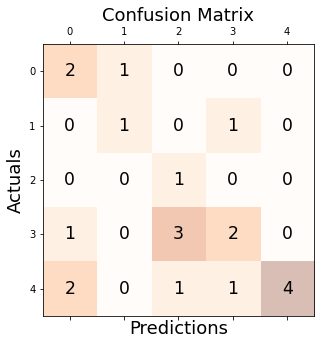

Recall: 0.600
Precision: 0.520
Accuracy: 0.500
F1 score: 0.480

Fold number 2:
```````````````


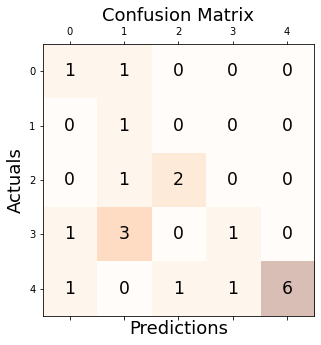

Recall: 0.607
Precision: 0.533
Accuracy: 0.550
F1 score: 0.488

Fold number 3:
```````````````


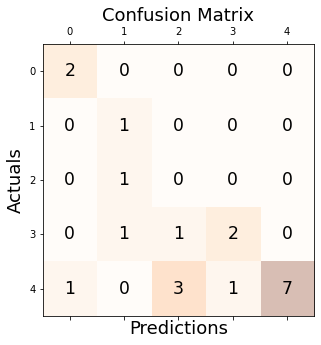

Recall: 0.617
Precision: 0.533
Accuracy: 0.600
F1 score: 0.522

Fold number 4:
```````````````


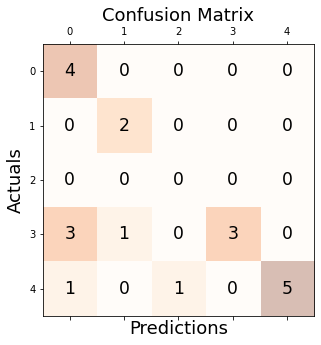

Recall: 0.629
Precision: 0.633
Accuracy: 0.700
F1 score: 0.580

Fold number 5:
```````````````


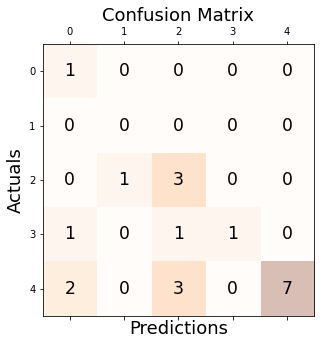

Recall: 0.533
Precision: 0.536
Accuracy: 0.600
F1 score: 0.436

Fold number 6:
```````````````


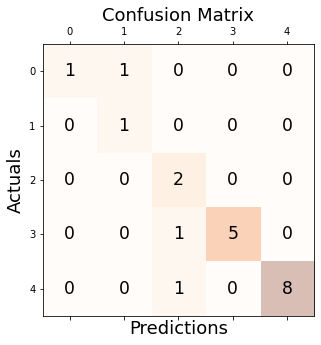

Recall: 0.844
Precision: 0.800
Accuracy: 0.850
F1 score: 0.770

Fold number 7:
```````````````


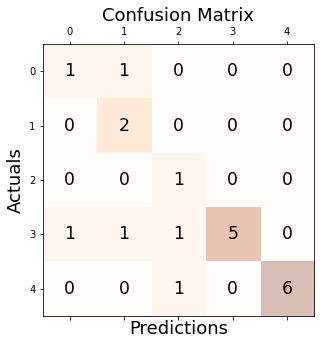

Recall: 0.796
Precision: 0.667
Accuracy: 0.750
F1 score: 0.672

Fold number 8:
```````````````


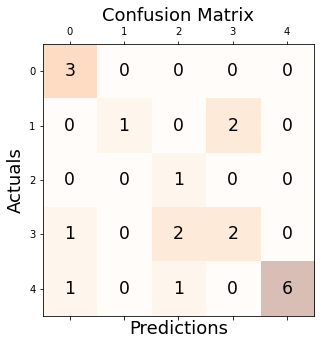

Recall: 0.697
Precision: 0.670
Accuracy: 0.650
F1 score: 0.590

Fold number 9:
```````````````


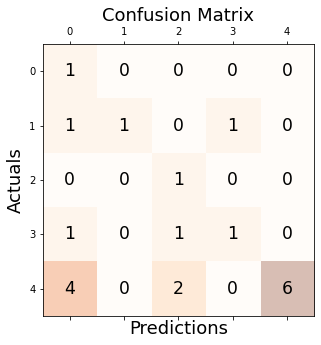

Recall: 0.633
Precision: 0.579
Accuracy: 0.500
F1 score: 0.443

Fold number 10:
```````````````


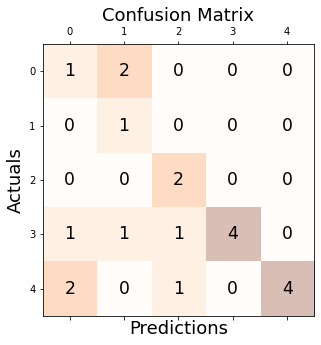

Recall: 0.695
Precision: 0.600
Accuracy: 0.600
F1 score: 0.561

Global metrics after 10 folds:
``````````````````````````````


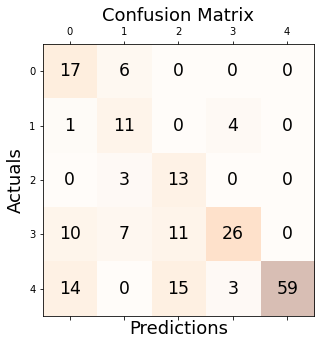

Recall: 0.674
Precision: 0.587
Accuracy: 0.630
F1 score: 0.578


In [16]:
# Generating models and evaluating their predictions

k_fold(features = selected_features,
       labels = drugs_col,
       k = 10,
       classifier = svm,
       rescale = True,
       rescaling_method = 'z',
       pca = True,
       pca_components = 3,
       resample = True,
       resampling_method = 'over',
       alpha = 0.001,
       epochs = 500,
       C = 1)


Fold number 1:
```````````````


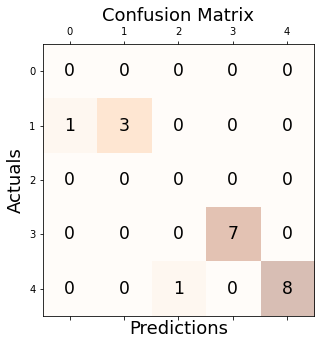

Recall: 0.528
Precision: 0.600
Accuracy: 0.900
F1 score: 0.560

Fold number 2:
```````````````


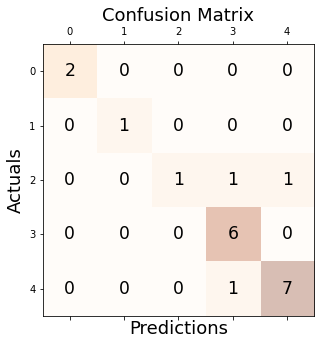

Recall: 0.842
Precision: 0.925
Accuracy: 0.850
F1 score: 0.846

Fold number 3:
```````````````


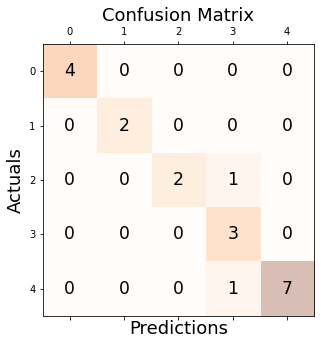

Recall: 0.908
Precision: 0.920
Accuracy: 0.900
F1 score: 0.897

Fold number 4:
```````````````


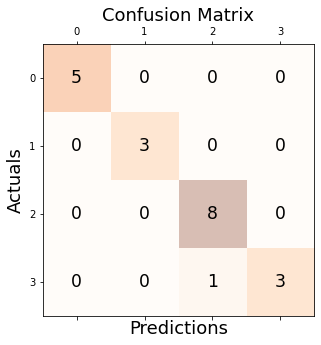

Recall: 0.938
Precision: 0.972
Accuracy: 0.950
F1 score: 0.950

Fold number 5:
```````````````


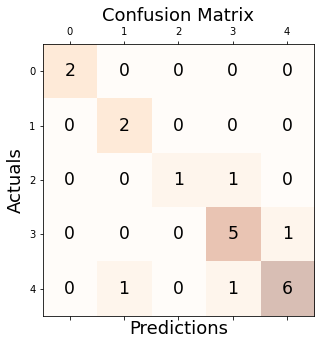

Recall: 0.817
Precision: 0.848
Accuracy: 0.800
F1 score: 0.807

Fold number 6:
```````````````


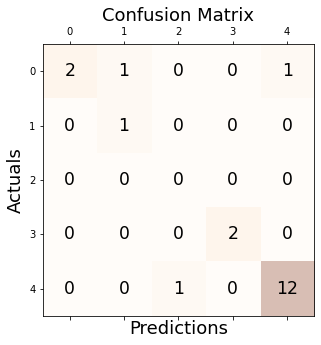

Recall: 0.685
Precision: 0.685
Accuracy: 0.850
F1 score: 0.651

Fold number 7:
```````````````


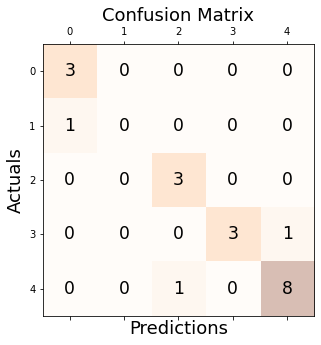

Recall: 0.728
Precision: 0.678
Accuracy: 0.850
F1 score: 0.692

Fold number 8:
```````````````


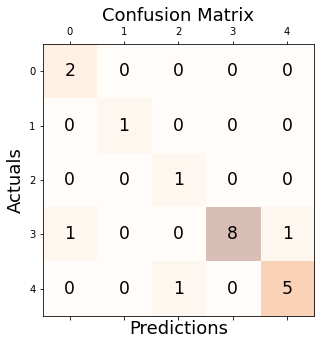

Recall: 0.927
Precision: 0.800
Accuracy: 0.850
F1 score: 0.838

Fold number 9:
```````````````


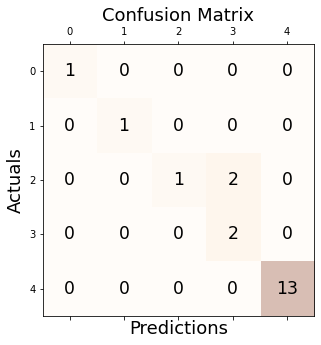

Recall: 0.867
Precision: 0.900
Accuracy: 0.900
F1 score: 0.833

Fold number 10:
```````````````


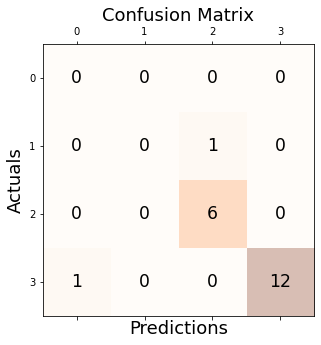

Recall: 0.481
Precision: 0.464
Accuracy: 0.900
F1 score: 0.471

Global metrics after 10 folds:
``````````````````````````````


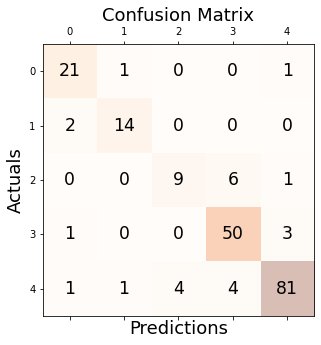

Recall: 0.833
Precision: 0.837
Accuracy: 0.875
F1 score: 0.833


In [17]:
k_fold(features = selected_categorised_features,
       labels = drugs_col,
       k = 10,
       classifier = cnb)


Fold number 1:
```````````````


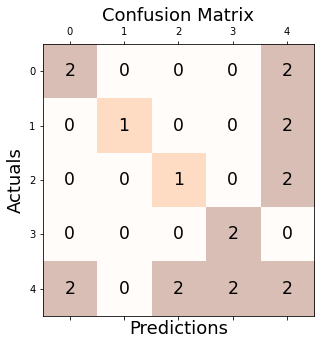

Recall: 0.483
Precision: 0.517
Accuracy: 0.400
F1 score: 0.450

Fold number 2:
```````````````


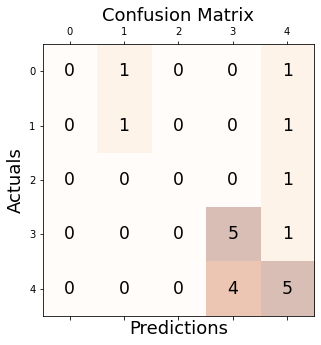

Recall: 0.378
Precision: 0.322
Accuracy: 0.550
F1 score: 0.344

Fold number 3:
```````````````


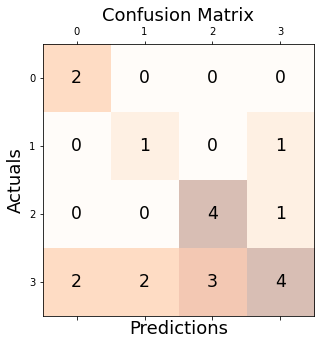

Recall: 0.666
Precision: 0.518
Accuracy: 0.550
F1 score: 0.551

Fold number 4:
```````````````


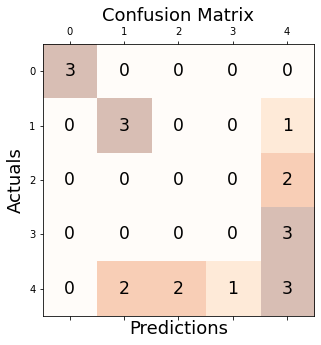

Recall: 0.425
Precision: 0.387
Accuracy: 0.450
F1 score: 0.404

Fold number 5:
```````````````


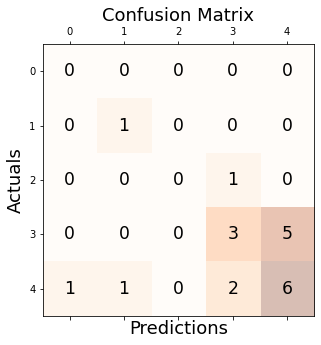

Recall: 0.395
Precision: 0.309
Accuracy: 0.500
F1 score: 0.333

Fold number 6:
```````````````


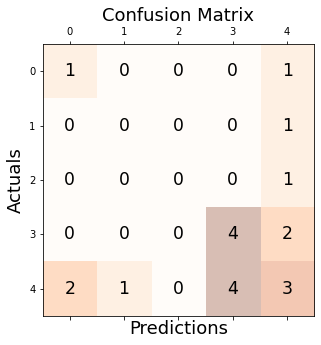

Recall: 0.293
Precision: 0.242
Accuracy: 0.400
F1 score: 0.261

Fold number 7:
```````````````


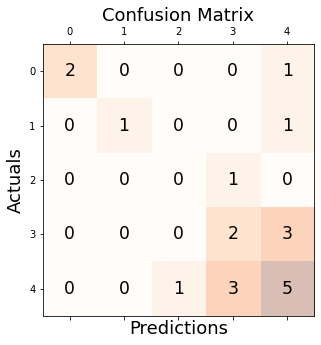

Recall: 0.424
Precision: 0.567
Accuracy: 0.500
F1 score: 0.471

Fold number 8:
```````````````


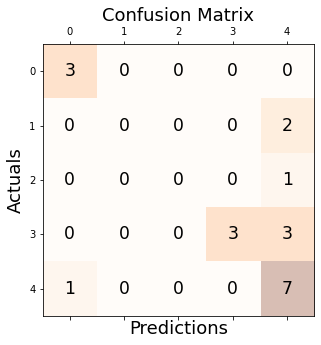

Recall: 0.475
Precision: 0.458
Accuracy: 0.650
F1 score: 0.438

Fold number 9:
```````````````


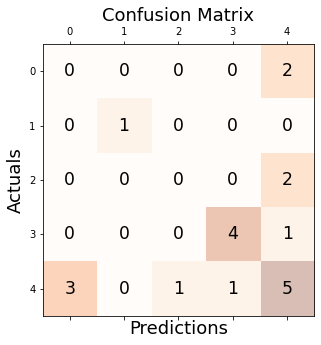

Recall: 0.460
Precision: 0.460
Accuracy: 0.500
F1 score: 0.460

Fold number 10:
```````````````


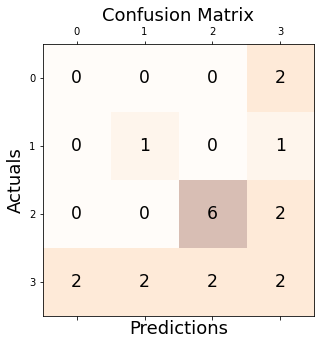

Recall: 0.375
Precision: 0.342
Accuracy: 0.450
F1 score: 0.354

Global metrics after 10 folds:
``````````````````````````````


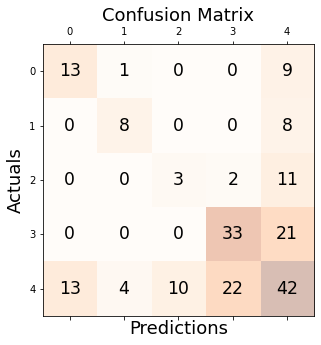

Recall: 0.465
Precision: 0.477
Accuracy: 0.495
F1 score: 0.469


In [18]:
k_fold(features = selected_features,
       labels = drugs_col,
       k = 10,
       classifier = dt,
       rescale = True,
       rescaling_method = 'mean_norm',
       pca = True,
       pca_components = 3,
       resample = True,
       resampling_method = 'over')